In [39]:
from fastai.vision.all import *
from fastbook import *
path = untar_data(URLs.MNIST_SAMPLE)

In [2]:
# Functions

class SimpleNN:
    def __init__(self, input_size, output_shape, std=1.0):
        self.weights = self.init_params((input_size, output_shape), std)
        self.bias = self.init_params(1)
        
    def init_params(self, size, std=1.0):
        return (torch.randn(size)*std).requires_grad_()

    def linear1(self, x):
        return x @ self.weights + self.bias
    
    @staticmethod
    def mnist_loss(prds,trgt):
        prds = prds.sigmoid()
        return torch.where(trgt==1, 1-prds, prds).mean()

    def calc_grad(self, batch_x, batch_y):
        preds = self.linear1(batch_x)
        loss = self.mnist_loss(preds, batch_y)
        loss.backward()
        
    def train_epoch(self, lr, dl):
        for batch_x, batch_y in dl:
            self.calc_grad(batch_x, batch_y)
            self.update_params(lr)

    def update_params(self, lr):
        for p in [self.weights, self.bias]:
            p.data -= p.grad*lr
            p.grad.zero_()
    
    def validate_epoch(self, valid_dl):
        accs = [self.batch_accuracy(self.linear1(x),y) for x,y in valid_dl]
        return round(torch.stack(accs).mean().item(), 4)
        
    @staticmethod
    def batch_accuracy(x, y):
        preds = x.sigmoid()
        correct = (preds>0.5) == y
        return correct.float().mean()

In [40]:
# Training data
train_threes = [tensor(Image.open(three)) for three in (path/'train'/'3').ls().sorted()]
train_seven = [tensor(Image.open(seven)) for seven in (path/'train'/'7').ls().sorted()]

stacked_threes_train = torch.stack(train_threes).float()/255 
stacked_seven_train = torch.stack(train_seven).float()/255

# Validation data
valid_threes = [tensor(Image.open(three)) for three in (path/'valid'/'3').ls().sorted()]
valid_seven = [tensor(Image.open(seven)) for seven in (path/'valid'/'7').ls().sorted()]

stacked_threes_valid = torch.stack(valid_threes).float()/255 
stacked_seven_valid = torch.stack(valid_seven).float()/255

# Zipping data with labels
## training ds
train_x = torch.cat([stacked_threes_train, stacked_seven_train]).view(-1, 28*28)
train_y = tensor([1]*len(train_threes) + [0]*len(train_seven)).unsqueeze(1)
train_dataset = list(zip(train_x, train_y))

## validation ds
valid_x = torch.cat([stacked_threes_valid, stacked_seven_valid]).view(-1, 28*28)
valid_y = tensor([1]*len(valid_threes) + [0]*len(valid_seven)).unsqueeze(1)
valid_dataset = list(zip(valid_x, valid_y))

# Create the batched data
## choosing batch size of 256 based on the books choice.  Seems arbitrary at this point.
train_ds = DataLoader(train_dataset, batch_size=256)
valid_ds = DataLoader(valid_dataset, batch_size=256)

In [47]:
for x,y in train_ds:
    print(x, "\n", y)

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]) 
 tensor([[1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
   

In [16]:
# Implement the model
epochs = 30
lr = 1

n = SimpleNN(28*28, 1)
for i in range(epochs):
    n.train_epoch(lr, train_ds)
    print(n.validate_epoch(valid_ds), end=' ')

0.6182 0.7964 0.9053 0.9336 0.9462 0.955 0.9633 0.9663 0.9682 0.9697 0.9731 0.9746 0.9746 0.976 0.977 0.9765 0.9765 0.977 0.9775 0.978 0.9795 0.9795 0.9799 0.9799 0.9804 0.9809 0.9809 0.9814 0.9814 0.9814 

In [17]:
linear_model = nn.Linear(28*28, 1)

w,b = linear_model.parameters()
w.shape, b.shape

(torch.Size([1, 784]), torch.Size([1]))

In [18]:
class BasicOptim:
    def __init__(self, params, lr):
        self.params, self.lr = list(params),lr
        
    def step(self, *args, **kwargs):
        for p in self.params:
            p.data -= p.grad.data * self.lr
            
    def zero_grad(self, *args, **kwargs):
        for p in self.params:
            p.grad = None
        

In [20]:
opt = BasicOptim(linear_model.parameters(), lr)

In [31]:


class SimpleLC:
    def __init__(self, params, lr, model):
        self.params = list(params)
        self.lr = lr
        self.model = model
        
    def step(self, *args, **kwargs):
        for p in self.params:
            p.data -= p.grad.data * self.lr
            
    def zero_grad(self, *args, **kwargs):
        for p in self.params:
            p.grad = None
            
    @staticmethod
    def cross_entropy_loss(preds, trgt, epsln=1e-7):
        preds = preds.sigmoid()
        preds = torch.clamp(preds, epsln, 1-epsln)
        N = preds.shape[0]
        sum_arg = trgt*torch.log(preds) + (1-trgt)*torch.log(1-preds)
        return  -(1/N)*torch.sum(sum_arg)
    
    @staticmethod
    def mnist_loss(prds,trgt):
        prds = prds.sigmoid()
        return torch.where(trgt==1, 1-prds, prds).mean()

    def calc_grad(self, batch_x, batch_y):
        preds = self.model(batch_x)
        loss = self.cross_entropy_loss(preds, batch_y)
        #loss = self.mnist_loss(preds, batch_y)
        loss.backward()
        
    def train_epoch(self, dl):
        for batch_x, batch_y in dl:
            self.calc_grad(batch_x, batch_y)
            self.step()
            self.zero_grad()

    def update_params(self, lr):
        for p in [self.weights, self.bias]:
            p.data -= p.grad*lr
            p.grad.zero_()
    
    def validate_epoch(self, valid_dl):
        accs = [self.batch_accuracy(self.model(x),y) for x,y in valid_dl]
        return round(torch.stack(accs).mean().item(), 4)
        
    @staticmethod
    def batch_accuracy(x, y):
        preds = x.sigmoid()
        correct = (preds>0.5) == y
        return correct.float().mean()

epochs = 40
lr = 1
linear_model1 = nn.Linear(28*28, 1)
layer1 = SimpleLC(linear_model1.parameters(),lr,linear_model1)

for i in range(epochs):
    layer1.train_epoch(train_ds)
    print(layer1.validate_epoch(valid_ds), end=" ")

0.8232 0.7812 0.9399 0.9517 0.9546 0.957 0.9585 0.9604 0.9599 0.9595 0.9609 0.9619 0.9619 0.9629 0.9634 0.9634 0.9638 0.9643 0.9643 0.9648 0.9663 0.9668 0.9677 0.9677 0.9677 0.9672 0.9677 0.9677 0.9677 0.9677 0.9677 0.9682 0.9677 0.9677 0.9682 0.9687 0.9687 0.9687 0.9692 0.9692 

In [32]:
class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleNN, self).__init__()
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.ReLU = nn.ReLU()
        self.linear2 = nn.Linear(hidden_size,output_size)
        
    def forward(self, x):
        x = self.linear1(x)
        x = self.ReLU(x)
        x = self.linear2(x)
        return x
    
def cross_entropy_loss(prds, trgt, epsln = 1e-7):
        prds = prds.sigmoid()
        prds = torch.clamp(prds, epsln, 1-epsln)
        N = prds.shape[0]
        sum_arg = trgt*torch.log(prds) + (1-trgt)*torch.log(1-prds)
        #print(-(1/N)*torch.sum(sum_arg))
        return  -(1/N)*torch.sum(sum_arg)
    
def mnist_loss(prds,trgt):
        prds = prds.sigmoid()
        return torch.where(trgt==1, 1-prds, prds).mean()
def validate_epoch(model, valid_dl):
        accs = [batch_accuracy(model(x),y) for x,y in valid_dl]
        return round(torch.stack(accs).mean().item(), 4)
    
def batch_accuracy(x, y):
        preds = x.sigmoid()
        correct = (preds>0.5) == y
        return correct.float().mean()
def run_model(model, opt, epochs, ds):
    for i in range(epochs):
        for train_x, train_y in ds:
        pred = n(train_x)

        loss =  cross_entropy_loss(pred, train_y)
        loss.backward()
        opt.step()
        opt.zero_grad()
    

In [51]:
n = SimpleNN(28*28, 30, 1)

epochs = 1
lr = 1 


opt = SGD(n.parameters(), lr)

for i in range(epochs):
    
    pred = n(train_x)
    
    loss =  cross_entropy_loss(pred, train_y)
    loss.backward()
    opt.step()
    opt.zero_grad()
    
    print(pred.shape)    

torch.Size([12396, 1])


In [34]:
loss

tensor(0.0263, grad_fn=<MulBackward0>)

In [ ]:
import matplotlib.pyplot as plt
plt.switch_backend('TkAgg')

In [9]:
def plot_in_realtime(losses, epochs):
    #  # Clear the current figure
    plt.plot(epochs,losses,label=f"Loss",)
    plt.xlabel("epoch", fontsize=6)
    plt.ylabel("Loss", fontsize=6)
    plt.legend(fontsize='small')
    plt.pause(0.001)
    plt.clf()

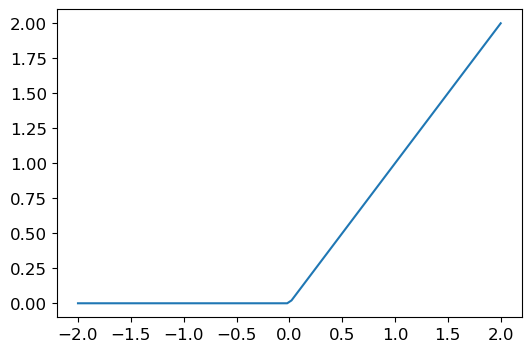

In [140]:
plot_function(F.relu)

In [4]:
# Extending the model to all digits

## Gathering the data


In [38]:
import pandas as pd

train = pd.read_csv("mnist_train.csv")
test = pd.read_csv("mnist_test.csv")

training = []
training_labels = []
validation = []
validation_labels = []
testing = []
testing_labels = []

def stacker(df):
    image_list = [torch.tensor(df.iloc[img].values) for img in range(len(df))]
    stacked = torch.stack(image_list).float()/255
    return stacked

for i in range(10):
    
    test_spec_digit = test[test["label"] == i]
    test_images = test_spec_digit.iloc[:, 1:785]
    
    spec_digit = train[train["label"] == i]
    images = spec_digit.iloc[:, 1:785]
    
    validation_images = images.iloc[0:(round(len(images)*.2)+1),].reset_index().drop(labels ="index", axis=1)
    
    train_images = images.iloc[(len(validation_images)+1):,].reset_index().drop(labels ="index", axis=1)
    
    test_stacked = stacker(test_images)
    testing_labels.extend([i]*len(test_stacked))
    testing.append(test_stacked)
    
    valid_stacked = stacker(validation_images)
    validation_labels.extend([i]*len(valid_stacked))
    validation.append(valid_stacked)
    
    train_stacked = stacker(train_images)
    training_labels.extend([i]*len(train_stacked))
    training.append(train_stacked)

    
testing = torch.cat(testing).view(-1, 28*28)
testing_labels = tensor(testing_labels).unsqueeze(1)
testing_data = list(zip(testing, testing_labels))


validation = torch.cat(validation).view(-1, 28*28)
validation_labels = tensor(validation_labels).unsqueeze(1)
validation_data = list(zip(validation, validation_labels))

training = torch.cat(training).view(-1, 28*28)
training_labels = tensor(training_labels).unsqueeze(1)
training_data = list(zip(training, training_labels))

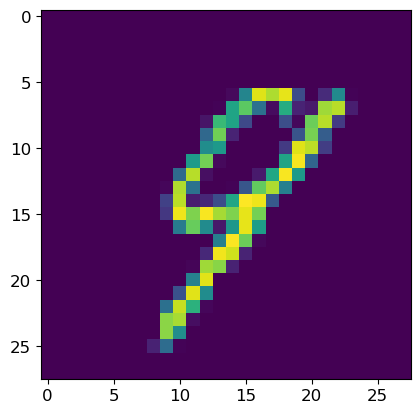

In [110]:
test= testing_data[9000][0]
array = test.numpy()
img = array.reshape(1,28,28)

img = np.transpose(img, (1, 2, 0))

import matplotlib.pyplot as plt
plt.imshow(img)

In [35]:
class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleNN, self).__init__()
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.ReLU = nn.ReLU()
        self.linear2 = nn.Linear(hidden_size,output_size)
        
    def forward(self, x):
        x = self.linear1(x)
        x = self.ReLU(x)
        x = self.linear2(x)
        return x
    
def mnist_loss(prds,trgt):
        prds = prds.sigmoid()
        return torch.where(trgt==1, 1-prds, prds).mean()

def validate_epoch(model, valid_dl):
        accs = [batch_accuracy(model(x),y) for x,y in valid_dl]
        return round(torch.stack(accs).mean().item(), 4)
    
def batch_accuracy(x, y):
        preds = x.sigmoid()
        correct = (preds>0.5) == y
        return correct.float().mean()